In [1]:
import numpy as np
from matplotlib import pyplot as plt
from pylab import *
from scipy.stats import norm
from scipy.stats import uniform
from astropy.io import fits
from astropy import units as u
import os
from IPython.display import Image
%matplotlib inline

In [2]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn import decomposition

## In this notebook, we build an emulator using SLICS and cosmo-SLICS simulation

In [10]:
############################################################
########### set the file path to already computed stats 
############################################################
root = '/global/u1/j/jialiu/NGphotoz/'
dir_storage = root+'NGphotoz_scratch/'
dir_cosmos = dir_storage+'Cosmo_maps/'
dir_cov = dir_storage+'Cov_maps/'

In [5]:
#############################################
##### parameters for smoothing and tomography
#############################################

##### smoothing scales in arcmin
theta_g_arr = [1,5,10]

##### tomographic bins
zarr = np.linspace(0,4, 501)
delta_z = 0.5
tomo_centers = np.arange(0.5, 3, delta_z) ## center for each redshift bin
tomo_arr = range(1,6) ## this is used for file name

####### 26 different cosmologies
####### Parameters are the same for seed _a and seed _f, only the IC differ.
cosmos = [ '%02d_%s'%(i, j) for j in ['a','f'] for i in range(25)]
cosmos += ['fid_a', 'fid_f']
print (cosmos)

####### light cone numbers
### lightcones: The LOS number runs from 74 to 1100, with some missing LOS. You will have 954 in total. 

cones_cov_full = arange(74, 1100)
cones_cosmo = arange(1,6)

['00_a', '01_a', '02_a', '03_a', '04_a', '05_a', '06_a', '07_a', '08_a', '09_a', '10_a', '11_a', '12_a', '13_a', '14_a', '15_a', '16_a', '17_a', '18_a', '19_a', '20_a', '21_a', '22_a', '23_a', '24_a', '00_f', '01_f', '02_f', '03_f', '04_f', '05_f', '06_f', '07_f', '08_f', '09_f', '10_f', '11_f', '12_f', '13_f', '14_f', '15_f', '16_f', '17_f', '18_f', '19_f', '20_f', '21_f', '22_f', '23_f', '24_f', 'fid_a', 'fid_f']


In [8]:
################################
###### cosmological parameters
################################

cosmo_params = np.genfromtxt(root+'CosmoTable.dat')
print (cosmo_params.shape)

IDs, Om_arr, h_arr, w0_arr, si8_arr, Oc_arr = cosmo_params.T 
##### we only care about Omega_m (Om_arr), h, w, and sigma8 (si8)

(26, 6)


In [6]:
################################################################
### functions to open the (alreacy computed) statistics
################################################################

def stats_gen_true (theta_g, tomo, cone):
    ipz='pz_true.txt'
    fn = dir_bias+'bias%s_tomo%i_cone%s_s%i.npy'%(ipz, tomo, cone, theta_g)
    return np.load(fn)

def stats_gen_cov (theta_g, tomo, cone): #### cone goes from 74 to 1099, missing some, total 953
    fn = dir_cov+'cov_tomo%i_cone%s_s%i.npy'%(tomo, cone, theta_g)
    return np.load(fn)

def stats_gen_cosmo (cosmo, theta_g, tomo, cone): 
    fn = dir_cosmos+'/%s_tomo%i_cone%s_s%i.npy'%(cosmo, tomo, cone, theta_g)
    return np.load(fn)

In [11]:
################################################################
### get measured statistics for cosmology-varying SLICS
################################################################

stats_raw = np.array([[[[stats_gen_cosmo(cosmo, theta_g, tomo, cone)
                        for tomo in tomo_arr] ## 5 tomo bins
                        for theta_g in theta_g_arr] ## 3 theta_g
                         for cone in cones_cosmo] ## 5 cones
                        for cosmo in cosmos] ## 2 seeds x 26 cosmos 
                       )

stats_cosmo = concatenate(stats_raw.reshape(2, 26, 5, 3, 5, 11, 10), axis=1)
print (stats_cosmo.shape)
####### axies: [26 cosmo, 10 realizations, 3 smoothing, 5 tomo bins, 11 stats/bin centers, 10 bins]

## the 11 stats/bins center are: 
## ell, ps_noiseless, ps_unsmoothed, ps_smoothed, kappa, peaks, minima, pdf, mf0, mf1, mf2

## more specifically (with index):
## ell(0), ps_noiseless(1), ps_unsmoothed(2), ps_smoothed(3), kappa(4), 
## peaks(5), minima(6), pdf(7), mf0(8), mf1(9), mf2(10)

(26, 10, 3, 5, 11, 10)


## Next, we building GP using sklearn 
#### following https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html


In [16]:
################################################################
### for test, use only 1 stat, 1 smoothing, and 1 tomographic bins
################################################################

itomo = 2 ## z=1.5
ismooth= 1 ## smoothing=5 arcmin
istat = 5 ## peaks

input_arr = stats_cosmo[:, :, ismooth, itomo, istat, :] ### peak counts, smoothing=5 (index=1), tomo bin = itomo
print ('input_arr.shape:', input_arr.shape)

kappa = stats_cosmo[0, 0, ismooth, itomo, 4, :]

##### compute the mean and standard deviation of the 26 cosmologies 
imean = mean(input_arr, axis=1).reshape(26,-1)
istd = std(input_arr, axis=1).reshape(26,-1)

####### each should have 26 x 10 shape, kappa should have 10 bins
print (imean.shape, istd.shape, kappa.shape)

input_arr.shape: (26, 10, 10)
(26, 10) (26, 10) (10,)


In [25]:
################################################################
### use only 1 stats, 1 smoothing, and 1 tomographic bins
################################################################
# idx=where(imean[-1]>0)[0] ## this one makes sure the fiducial cosmology has nonzero counts
idx=where(amin(imean,axis=0)>0)[0] ## this one all cosmology has nonzero counts
print ('The number of nonzero bins left:', len(idx))

The number of nonzero bins left: 6


In [26]:
#################################
#### building GP 
##################################
              
##### cosmological parameters, only using Om_arr, h_arr, w0_arr, si8_arr
X = cosmo_params[:, 1:-1]
print ('cosmo parameters shape (N_cosmology, N_parameters):', X.shape)

##### observations and noise
Y = imean[:,idx]
dY = istd[:,idx]

print ('full set mean (N_cosmology, N_bins):', Y.shape)
print ('full set std  (N_cosmology, N_bins):', dY.shape)

## remove 1 point from the training set for testing purpose
Ntest = 25 ## cosmology #25 is the fiducial model
Xtrue, Ytrue = X[Ntest], Y[Ntest]
Xtest, Ytest, dYtest = [delete(arr, Ntest, axis=0) for arr in [X, Y, dY]]

print (Xtrue)
## add 1 dimension, somehow the GP code needs this
Xtrue = expand_dims(Xtrue, axis=0) 

cosmo parameters shape (N_cosmology, N_parameters): (26, 4)
full set mean (N_cosmology, N_bins): (26, 6)
full set std  (N_cosmology, N_bins): (26, 6)
[ 0.2905  0.6898 -1.      0.8364]


#### set up kernel and gp, need extensive tests on the kernel selection and gp parameters...

(0.5, 1.5)

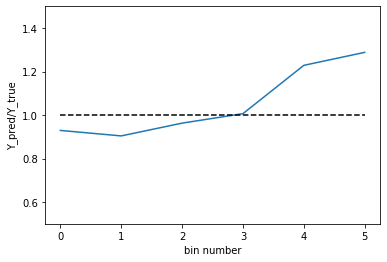

In [33]:
kernel = C(1.0, (1e-5, 1e5)) * RBF(1.0, length_scale_bounds=(1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True)
gp.fit(Xtest, Ytest)
Ypred = gp.predict(Xtrue).ravel()
plot(Ypred/Ytrue)
plot(ones(len(idx)), 'k--')
xlabel('bin number')
ylabel('Y_pred/Y_true')
ylim(0.5, 1.5)

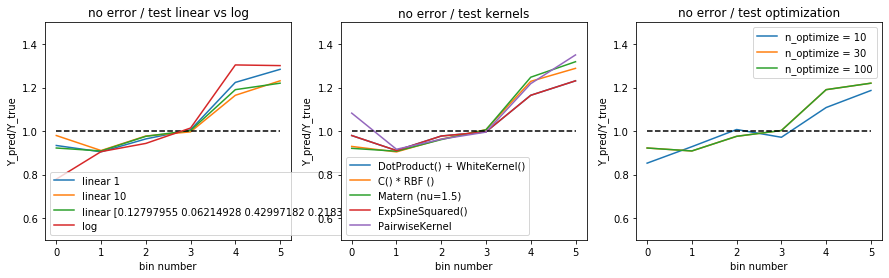

In [37]:
################################################################
#### some examples of tests... none of these works yet... 
#### the goals it to reach Y_pred = Y_true as closely as possible
#################################################################

figure(figsize=(15,4))
Xstd=std(X, axis=0)

######## test kernel
subplot(131)
for irbf in [1, 10, Xstd]:
    kernel = C(1, (1e-3, 1e3)) * RBF(irbf, length_scale_bounds=(1e-2, 1e2)) 
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True)
    gp.fit(Xtest, Ytest)
    Ypred = gp.predict(Xtrue).ravel()
    plot(Ypred/Ytrue, label='linear %s'%(irbf))
plot(ones(len(idx)), 'k--')

########## test log
Ytest_log = log10(Ytest)
kernel = C(1.0, (1e-3, 1e3)) * RBF(1, length_scale_bounds=(1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True)
gp.fit(Xtest, Ytest_log)
Ypred = gp.predict(Xtrue).ravel()
plot(10**Ypred/Ytrue, label='log')

title('no error / test linear vs log')
xlabel('bin number')
ylabel('Y_pred/Y_true')
ylim(0.5, 1.5)
legend()


######## test kernel
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, Matern, ExpSineSquared, PairwiseKernel
kernels = [DotProduct() + WhiteKernel(),  C() * RBF (), Matern (nu=1.5), ExpSineSquared(),PairwiseKernel()]
kernel_names = ['DotProduct() + WhiteKernel()',  'C() * RBF ()', 'Matern (nu=1.5)', 'ExpSineSquared()', 'PairwiseKernel']
subplot(132)

for i in range(len(kernels)):
    ikernel = kernels[i]
    ikernel_name = kernel_names[i]
    gp = GaussianProcessRegressor(kernel=ikernel, n_restarts_optimizer=10, normalize_y=True)
    gp.fit(Xtest, Ytest)
    Ypred = gp.predict(Xtrue).ravel()
    plot(Ypred/Ytrue, label='%s'%(ikernel_name))
plot(ones(len(idx)), 'k--')    
title('no error / test kernels')
xlabel('bin number')
ylabel('Y_pred/Y_true')
ylim(0.5, 1.5)
legend()

####### test optimization -- doesn't matter
subplot(133)
for Nopt in [10, 30, 100]:
    kernel = C(1, (1e-3, 1e3)) * RBF(Xstd, length_scale_bounds=(1e-2, 1e2)) 
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=Nopt, normalize_y=True)#, alpha=idY ** 2)
    gp.fit(Xtest, Ytest)
    Ypred = gp.predict(Xtrue).ravel()
    plot(Ypred/Ytrue, label='n_optimize = %s'%(Nopt))
plot(ones(len(idx)), 'k--')
title('no error / test optimization')
xlabel('bin number')
ylabel('Y_pred/Y_true')
ylim(0.5, 1.5)
legend()
show()